In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:158: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:42: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:46: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:49: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [30]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [31]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')
sector_rtns['All']=np.log(cleansed.resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """


In [32]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)
sector_portfolio_sorts['All']=quantile_portfolios_annual(data,cleansed,2)

In [37]:
factors=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors[s]=sector_portfolio_sorts[s]['1']-sector_portfolio_sorts[s]['0']


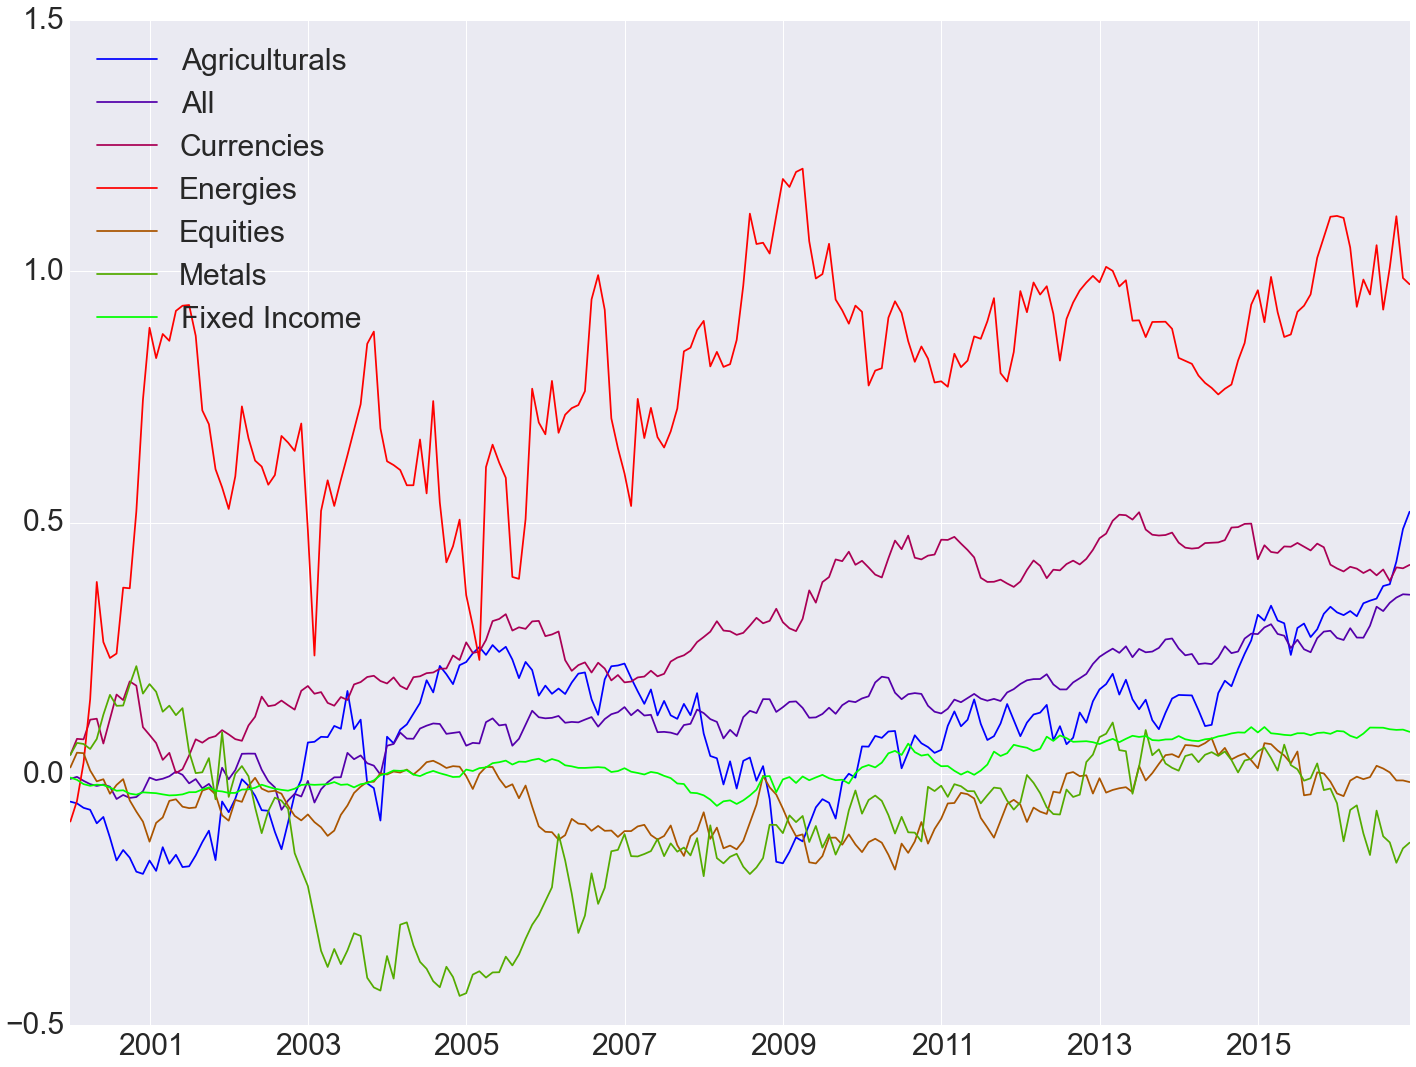

In [38]:
factors.cumsum().plot(colormap='brg')

In [39]:
final_res=pd.DataFrame()
alpha={}
tstat={}
for sec in factors.columns:
    ind=factors.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha1']=pd.Series(alpha)*100
final_res['tstat']=pd.Series(tstat)

In [40]:
final_res

,alpha1,tstat
Agriculturals,0.315777,1.349242
All,0.162988,1.430718
Currencies,0.204542,1.390293
Energies,0.624799,1.021351
Equities,-0.012194,-0.074674
Fixed Income,0.047579,0.879938
Metals,-0.124955,-0.504142


# FHT Annual portfolio sorts

In [41]:
FHT=calculate_FHT(cleansed)
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(FHT)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [42]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)
sector_portfolio_sorts['All']=quantile_portfolios_annual(FHT,cleansed,2)

In [48]:
factors_FHT=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors_FHT[s]=sector_portfolio_sorts[s]['1']-sector_portfolio_sorts[s]['0']


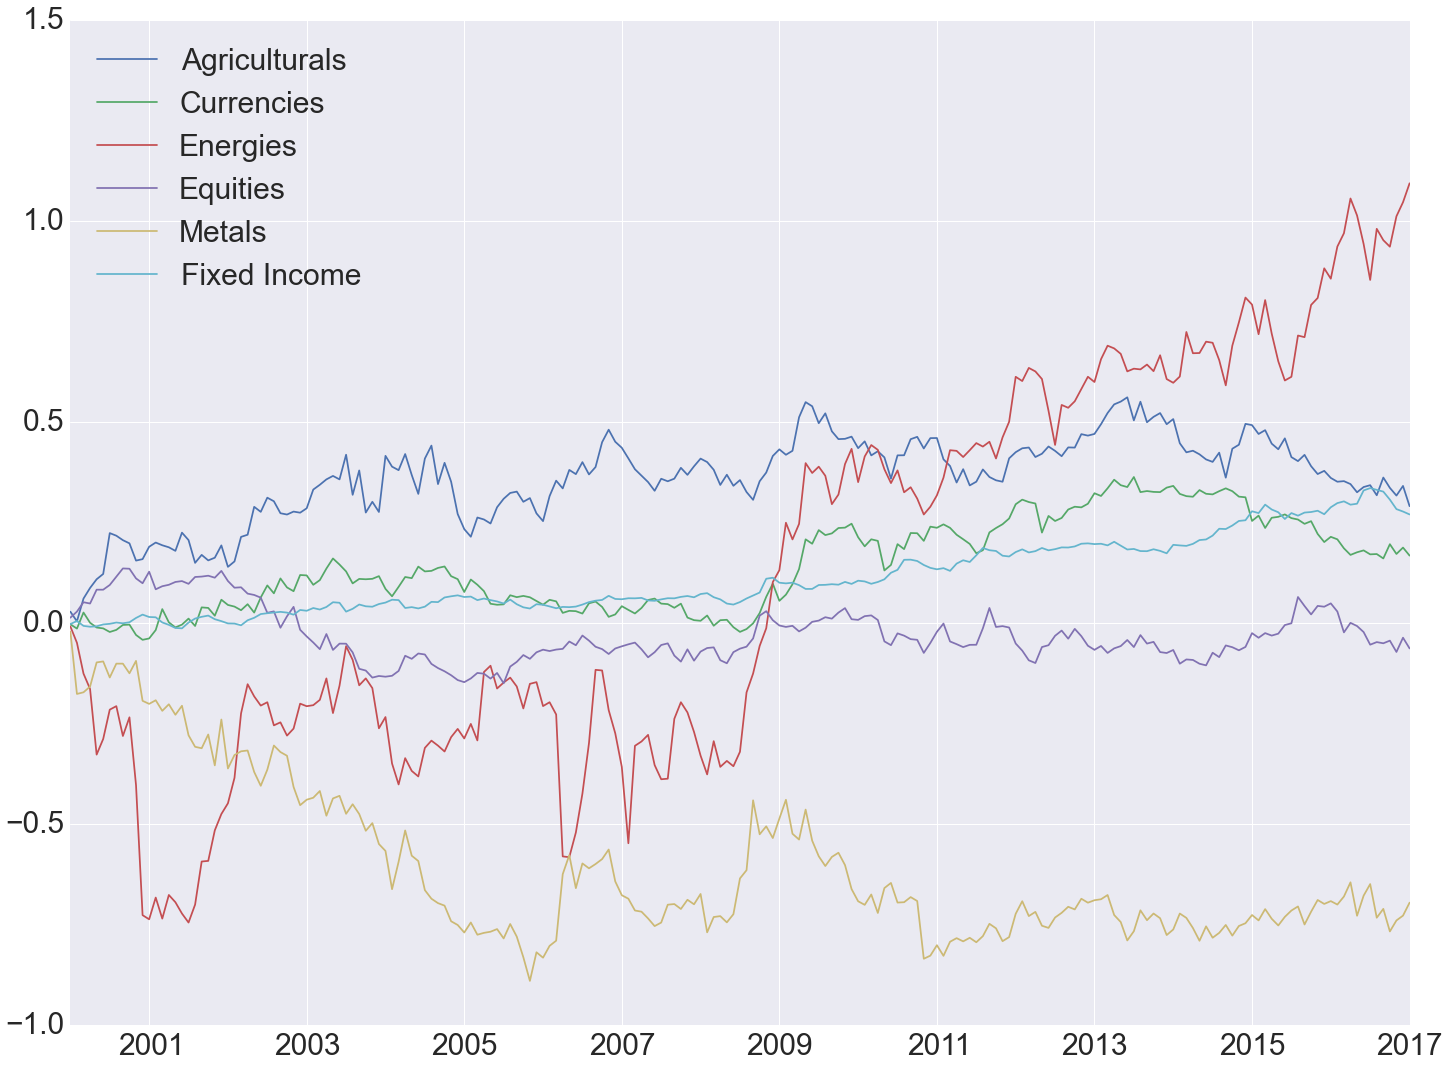

In [27]:
factors_FHT['2000':].cumsum().plot()

In [55]:
alpha={}
tstat={}
for sec in factors_FHT.columns:
    ind=factors_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_FHT[sec]['2000':'2016'],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha F-A']=pd.Series(alpha)*100
final_res['tstat2']=pd.Series(tstat)

In [56]:
final_res

,alpha1,tstat,alpha F-A,tstat2
Agriculturals,0.315777,1.349242,0.200180,0.911081
All,0.162988,1.430718,0.292464,2.858574
Currencies,0.204542,1.390293,0.080995,0.547791
Energies,0.624799,1.021351,0.556008,1.044775
Equities,-0.012194,-0.074674,0.055616,0.419850
Fixed Income,0.047579,0.879938,0.055512,1.635207
Metals,-0.124955,-0.504142,-0.250844,-0.875566


# Monthly portoflio sorts

In [88]:
amihud_monthly = read_monthly(amihud=True)

In [89]:
factors_monthly=pd.DataFrame()
for s in amihud_monthly.keys():
    factors_monthly[s]=amihud_monthly[s]['1']-amihud_monthly[s]['0']


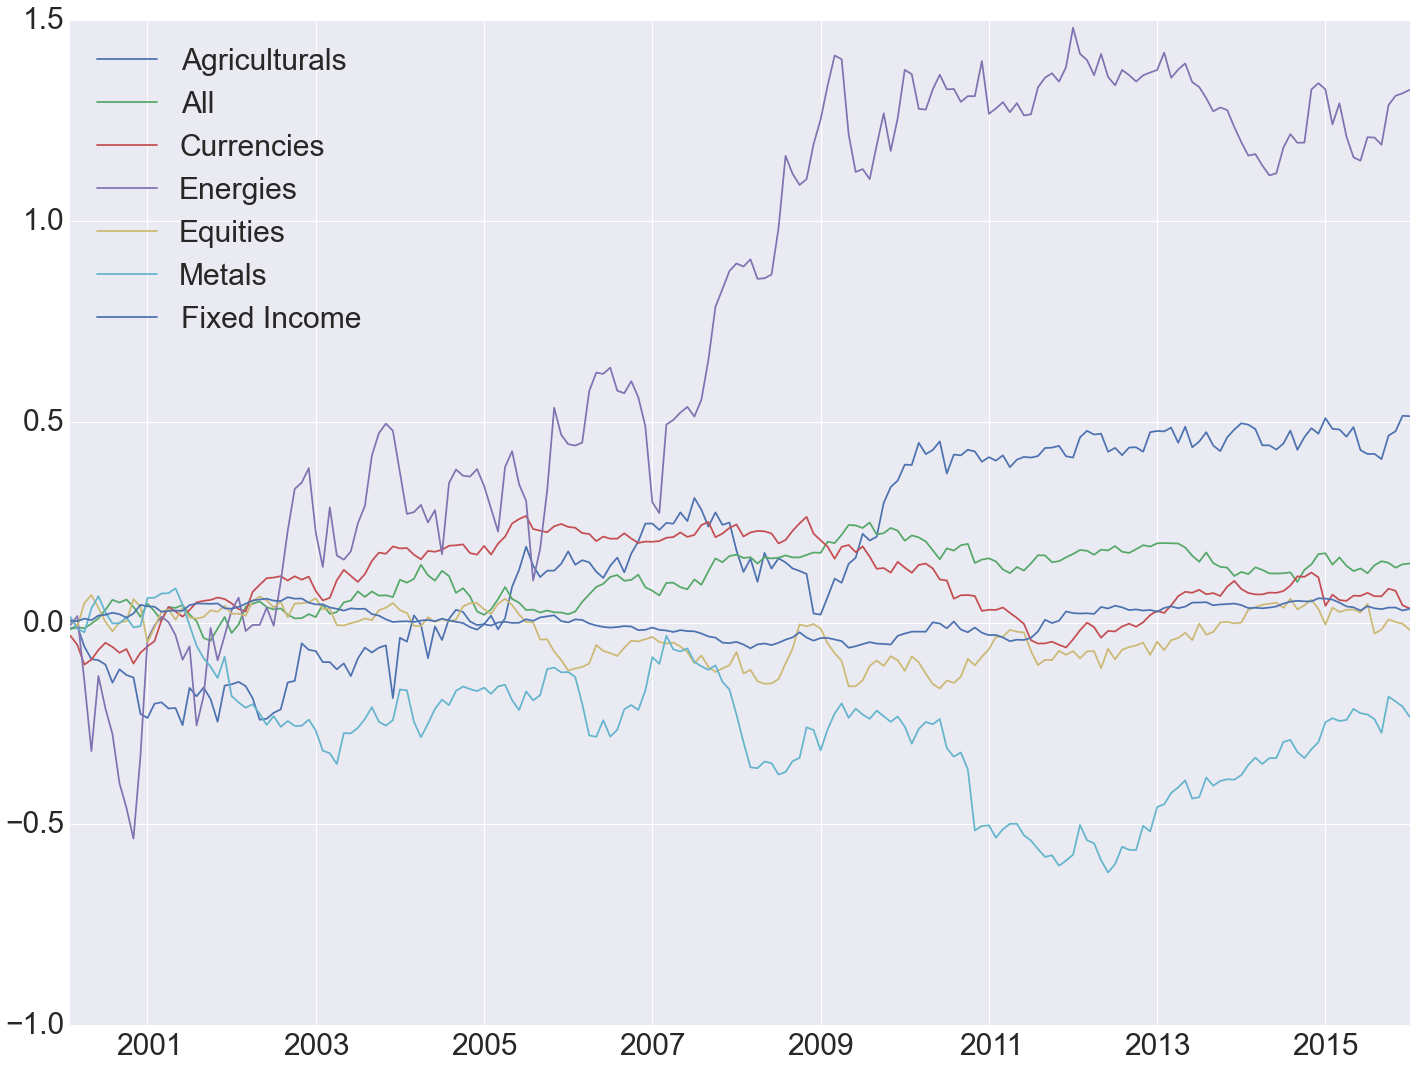

In [90]:
factors_monthly.cumsum().plot()

In [106]:
alpha={}
tstat={}
for sec in factors_monthly.columns:
    ind=factors_monthly['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_monthly[sec].loc[ind],reges.loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha A-M']=pd.Series(alpha)*100
final_res['tstat3']=pd.Series(tstat)

In [107]:
final_res

,alpha1,tstat,alpha F-A,tstat2,alpha A-M,tstat3,alpha F-M,tstat4
Agriculturals,0.315777,1.349242,0.200180,0.911081,0.291606,1.244282,NaN,NaN
All,0.162988,1.430718,0.292464,2.858574,0.189316,1.511003,NaN,NaN
Currencies,0.204542,1.390293,0.080995,0.547791,-0.022593,-0.164484,NaN,NaN
Energies,0.624799,1.021351,0.556008,1.044775,0.737500,1.183922,NaN,NaN
Equities,-0.012194,-0.074674,0.055616,0.419850,0.039624,0.234738,NaN,NaN
Fixed Income,0.047579,0.879938,0.055512,1.635207,0.035341,0.636916,NaN,NaN
Metals,-0.124955,-0.504142,-0.250844,-0.875566,-0.146062,-0.578791,NaN,NaN


# Monthly FHT

In [108]:
FHT_monthly = read_monthly(amihud=False)

In [109]:
factors_monthly_FHT=pd.DataFrame()
for s in FHT_monthly.keys():
    factors_monthly_FHT[s]=FHT_monthly[s]['1']-FHT_monthly[s]['0']


In [112]:
alpha={}
tstat={}
for sec in factors_monthly_FHT.columns:
    ind=factors_monthly_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_monthly_FHT[sec].loc[ind],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha F-M']=pd.Series(alpha)*100
final_res['tstat4']=pd.Series(tstat)

In [113]:
final_res

,alpha1,tstat,alpha F-A,tstat2,alpha A-M,tstat3,alpha F-M,tstat4
Agriculturals,0.315777,1.349242,0.200180,0.911081,0.291606,1.244282,-0.354284,-1.326237
All,0.162988,1.430718,0.292464,2.858574,0.189316,1.511003,0.009959,0.082577
Currencies,0.204542,1.390293,0.080995,0.547791,-0.022593,-0.164484,0.044892,0.289043
Energies,0.624799,1.021351,0.556008,1.044775,0.737500,1.183922,0.835449,1.563453
Equities,-0.012194,-0.074674,0.055616,0.419850,0.039624,0.234738,0.196749,1.293374
Fixed Income,0.047579,0.879938,0.055512,1.635207,0.035341,0.636916,-0.015800,-0.346752
Metals,-0.124955,-0.504142,-0.250844,-0.875566,-0.146062,-0.578791,-0.004883,-0.018995


# Alpha values 

$$r_{liquidity,t} = \alpha + \beta_1 r_{AssetClass,t} + \beta_2 MOM_{AssetClass,t} +
\beta_3 VAL_{AssetClass,t} + \varepsilon_t $$

In [114]:
print(final_res.T.round(2).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Agriculturals &   All &  Currencies &  Energies &  Equities &  Fixed Income &  Metals \\
\midrule
alpha1    &           0.32 &  0.16 &        0.20 &      0.62 &     -0.01 &          0.05 &   -0.12 \\
tstat     &           1.35 &  1.43 &        1.39 &      1.02 &     -0.07 &          0.88 &   -0.50 \\
alpha F-A &           0.20 &  0.29 &        0.08 &      0.56 &      0.06 &          0.06 &   -0.25 \\
tstat2    &           0.91 &  2.86 &        0.55 &      1.04 &      0.42 &          1.64 &   -0.88 \\
alpha A-M &           0.29 &  0.19 &       -0.02 &      0.74 &      0.04 &          0.04 &   -0.15 \\
tstat3    &           1.24 &  1.51 &       -0.16 &      1.18 &      0.23 &          0.64 &   -0.58 \\
alpha F-M &          -0.35 &  0.01 &        0.04 &      0.84 &      0.20 &         -0.02 &   -0.00 \\
tstat4    &          -1.33 &  0.08 &        0.29 &      1.56 &      1.29 &         -0.35 &   -0.02 \\
\bottomrule
\end{tabular}



In [120]:
print final_res.T[[u'Agriculturals', u'Currencies', u'Energies', u'Equities',
       u'Fixed Income', u'Metals', u'All']].round(2).to_latex()


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Agriculturals &  Currencies &  Energies &  Equities &  Fixed Income &  Metals &   All \\
\midrule
alpha1    &           0.32 &        0.20 &      0.62 &     -0.01 &          0.05 &   -0.12 &  0.16 \\
tstat     &           1.35 &        1.39 &      1.02 &     -0.07 &          0.88 &   -0.50 &  1.43 \\
alpha F-A &           0.20 &        0.08 &      0.56 &      0.06 &          0.06 &   -0.25 &  0.29 \\
tstat2    &           0.91 &        0.55 &      1.04 &      0.42 &          1.64 &   -0.88 &  2.86 \\
alpha A-M &           0.29 &       -0.02 &      0.74 &      0.04 &          0.04 &   -0.15 &  0.19 \\
tstat3    &           1.24 &       -0.16 &      1.18 &      0.23 &          0.64 &   -0.58 &  1.51 \\
alpha F-M &          -0.35 &        0.04 &      0.84 &      0.20 &         -0.02 &   -0.00 &  0.01 \\
tstat4    &          -1.33 &        0.29 &      1.56 &      1.29 &         -0.35 &   -0.02 &  0.08 \\
\bottomrule
\end{tabular}

